In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.api as sm

sns.set_theme()
sns.set_context("talk")
sns.set_palette("colorblind")

colors = sns.color_palette("colorblind")
date_form = DateFormatter("%Y-%m-%d\n%H:%M")


In [2]:
sml_lt_df = pd.read_csv("Data/SML LT 2001.csv")
sml_lt_df['Date_UTC'] = pd.to_datetime(sml_lt_df['Date_UTC'])

sme_df = pd.read_csv("Data/SME 2001.csv")
sme_df['Date_UTC'] = pd.to_datetime(sme_df['Date_UTC'])

ng2011df = pd.read_csv("Data/substorms-newell-20000101_000000_to_20070101_000000.csv")
ng2011df['Date_UTC'] = pd.to_datetime(ng2011df['Date_UTC'])
ng2011_2001 = ng2011df[ng2011df['Date_UTC'].dt.year == 2001].reset_index(drop=True)

In [25]:
sml_lt_df

,Date_UTC,SMLr00,SMLr01,SMLr02,SMLr03,SMLr04,SMLr05,SMLr06,SMLr07,SMLr08,...,SMLr14,SMLr15,SMLr16,SMLr17,SMLr18,SMLr19,SMLr20,SMLr21,SMLr22,SMLr23
0,2001-01-01 00:00:00,-12,-12,-9,-8,-2,-2,-2,0,-2,...,-9,-13,-13,-14,-14,-14,-7,-7,-7,-12
1,2001-01-01 00:01:00,-11,-11,-9,-8,-2,-2,-2,0,-2,...,-8,-13,-13,-14,-14,-14,-8,-8,-8,-11
2,2001-01-01 00:02:00,-11,-11,-8,-8,-3,-3,-3,0,-3,...,-8,-12,-12,-12,-13,-13,-13,-8,-8,-11
3,2001-01-01 00:03:00,-11,-11,-8,-8,-4,-4,-4,0,-3,...,-8,-12,-12,-12,-14,-14,-14,-8,-8,-11
4,2001-01-01 00:04:00,-11,-11,-8,-8,-4,-4,-4,0,-2,...,-8,-13,-13,-13,-14,-14,-14,-7,-7,-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,2001-12-31 23:55:00,-44,-32,-32,-32,-32,-32,-32,-23,-12,...,-16,-20,-24,-24,-30,-30,-30,-12,-44,-44
525596,2001-12-31 23:56:00,-45,-29,-29,-29,-29,-29,-29,-23,-10,...,-16,-21,-24,-24,-30,-30,-30,-12,-45,-45
525597,2001-12-31 23:57:00,-45,-45,-28,-27,-23,-23,-23,-23,-10,...,-16,-21,-24,-24,-30,-30,-30,-12,-24,-45
525598,2001-12-31 23:58:00,-45,-45,-28,-28,-20,-23,-23,-23,-10,...,-17,-21,-24,-24,-30,-30,-30,-12,-24,-45


In [3]:
no_sectors = 7
MLT_sectors = np.concatenate([np.arange((24-np.floor(no_sectors/2)), 24), np.arange(0, no_sectors/2)]).ravel().astype(int)
allsec = [i for i in np.arange(0,24)]
allsec_names = [f'SMLr{i:02d}' for i in allsec]
MLT_sec_names =  [f'SMLr{i:02d}' for i in MLT_sectors]
SMLnightdf = pd.DataFrame({'Date_UTC':sml_lt_df['Date_UTC'],'SMLnight':sml_lt_df[MLT_sec_names].min(axis=1)})
SMLalldf = pd.DataFrame({'Date_UTC':sml_lt_df['Date_UTC'],'SMLall':sml_lt_df[allsec_names].min(axis=1)})

In [4]:
smlnight_scaled =((SMLnightdf['SMLnight'] - SMLnightdf['SMLnight'].mean())/SMLnightdf['SMLnight'].std()).to_numpy()
sml_scaled = ((sme_df['SML'] - sme_df['SML'].mean())/sme_df['SML'].std()).to_numpy()


## Descriptive statistics of the SML nightside modification

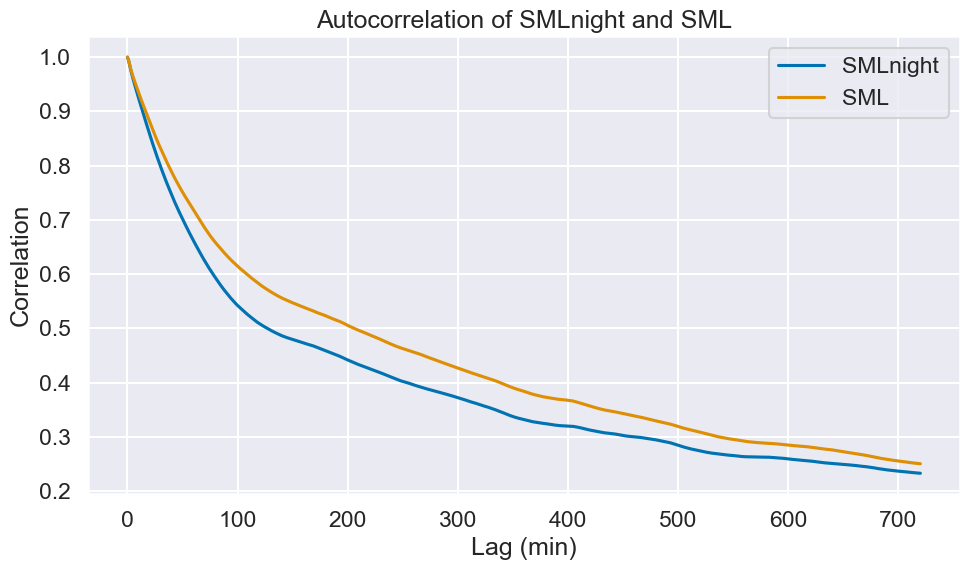

In [5]:
sml5_acorr = sm.tsa.stattools.acf(smlnight_scaled, nlags=12*60)
sml_acorr = sm.tsa.stattools.acf(sml_scaled, nlags=12*60)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sml5_acorr, label='SMLnight')
ax.plot(sml_acorr, label='SML')
ax.set_xlabel('Lag (min)')
ax.set_ylabel('Correlation')
ax.legend()
ax.set_title('Autocorrelation of SMLnight and SML')

plt.tight_layout(pad=1)

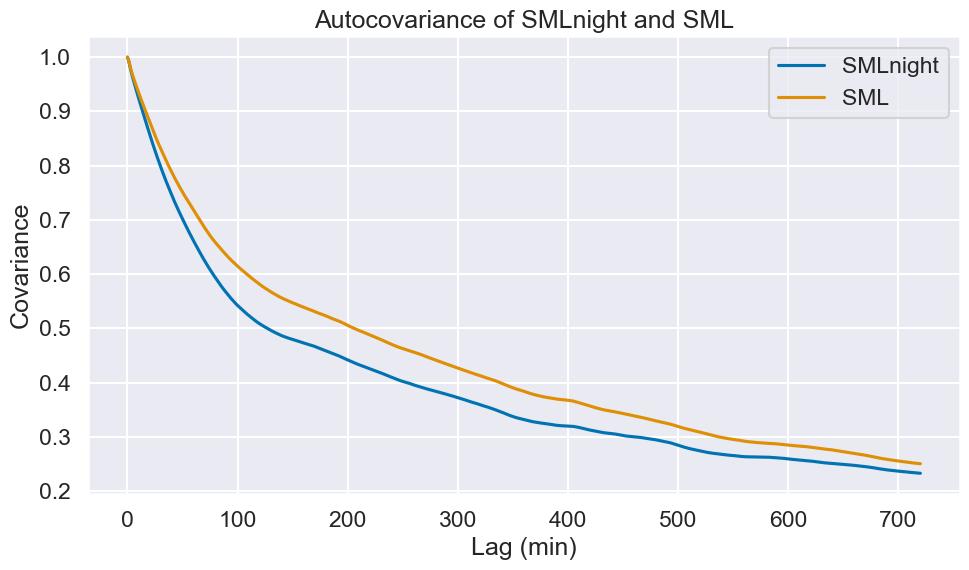

In [6]:
sml5_acov = sm.tsa.stattools.acovf(smlnight_scaled, nlag=12*60)
sml_acov = sm.tsa.stattools.acovf(sml_scaled, nlag=12*60)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sml5_acov, label='SMLnight')
ax.plot(sml_acov, label='SML')
ax.set_xlabel('Lag (min)')
ax.set_ylabel('Covariance')
ax.legend()
ax.set_title('Autocovariance of SMLnight and SML')

plt.tight_layout(pad=1)

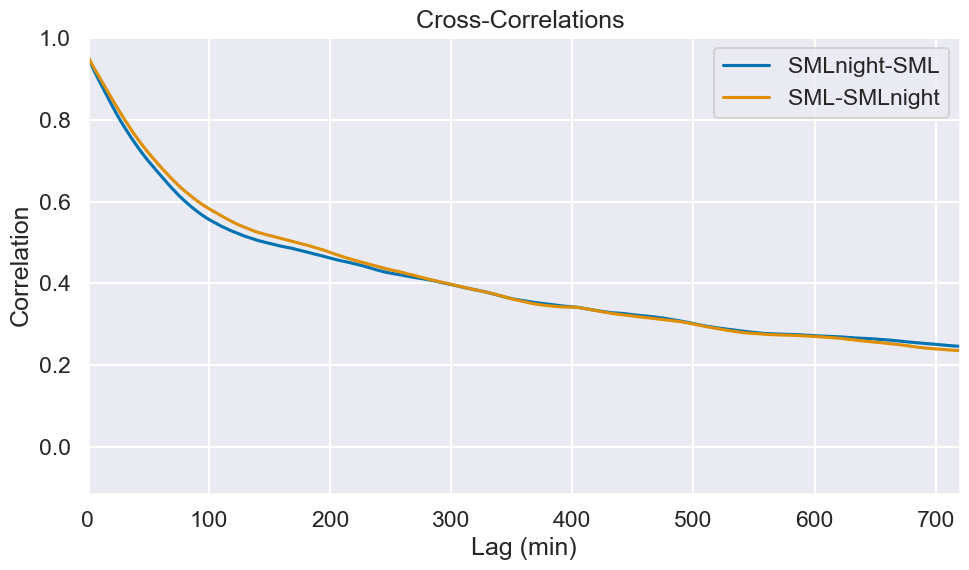

In [7]:
sml5_ccorr = sm.tsa.ccf(smlnight_scaled, sml_scaled, adjusted=False)
sml_ccorr = sm.tsa.ccf(sml_scaled, smlnight_scaled, adjusted=False)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sml5_ccorr, label='SMLnight-SML')
ax.plot(sml_ccorr, label='SML-SMLnight')
ax.set_xlabel('Lag (min)')
ax.set_ylabel('Correlation')
ax.legend()
ax.set_title('Cross-Correlations ')
ax.set_xlim(0, 12*60)
plt.tight_layout(pad=1)


## Substorm Identification on the new SMLnightside

In [8]:
onsettimes = []
onsetsectors = []
minimas = []
minimatimes = []
sml_array = sml_lt_df[MLT_sec_names].values

untilnext = 0
for index, __ in SMLnightdf[:-30].iterrows():
    onsettime = SMLnightdf['Date_UTC'][index]
    onsetsml = SMLnightdf['SMLnight'][index]
    onsetsector = np.where(sml_array[index]==onsetsml)[0]
    if untilnext > 1:
        untilnext -= 1
        continue
    if (SMLnightdf['SMLnight'][index + 1] - onsetsml) < -15:
        if (SMLnightdf['SMLnight'][index + 2] - onsetsml) < -30:
            if (SMLnightdf['SMLnight'][index + 3] - onsetsml) < -45:
                window = SMLnightdf['SMLnight'][index + 4:index + 30]
                if np.sum(window)/26 - onsetsml < -100:
                    onsettimes.append(onsettime)
                    onsetsectors.append(', '.join([str(element) for element in MLT_sectors[onsetsector]]))
                    minimas.append(window.min())
                    minimatimes.append(SMLnightdf['Date_UTC'][window.idxmin()])
                    untilnext = 20
    else:
        untilnext -= 1
        
ng2011_night = pd.DataFrame({'Date_UTC':onsettimes, 'MLT_onset':onsetsectors, 'SML_Minima': minimas, 'Date_UTC_minima': minimatimes})

In [24]:
ng2011_night

,Date_UTC,MLT_onset,SML_Minima,Date_UTC_minima
0,2001-01-01 06:23:00,"22, 23, 0",-279,2001-01-01 06:45:00
1,2001-01-02 18:16:00,"22, 23, 0",-235,2001-01-02 18:22:00
2,2001-01-02 22:24:00,"22, 23, 0",-267,2001-01-02 22:33:00
3,2001-01-03 02:56:00,"1, 2, 3",-537,2001-01-03 03:21:00
4,2001-01-03 11:03:00,"23, 0, 1",-637,2001-01-03 11:31:00
...,...,...,...,...
1467,2001-12-31 09:24:00,"21, 22, 23",-307,2001-12-31 09:53:00
1468,2001-12-31 16:23:00,3,-569,2001-12-31 16:31:00
1469,2001-12-31 18:01:00,"2, 3",-453,2001-12-31 18:07:00
1470,2001-12-31 19:38:00,3,-1035,2001-12-31 20:04:00


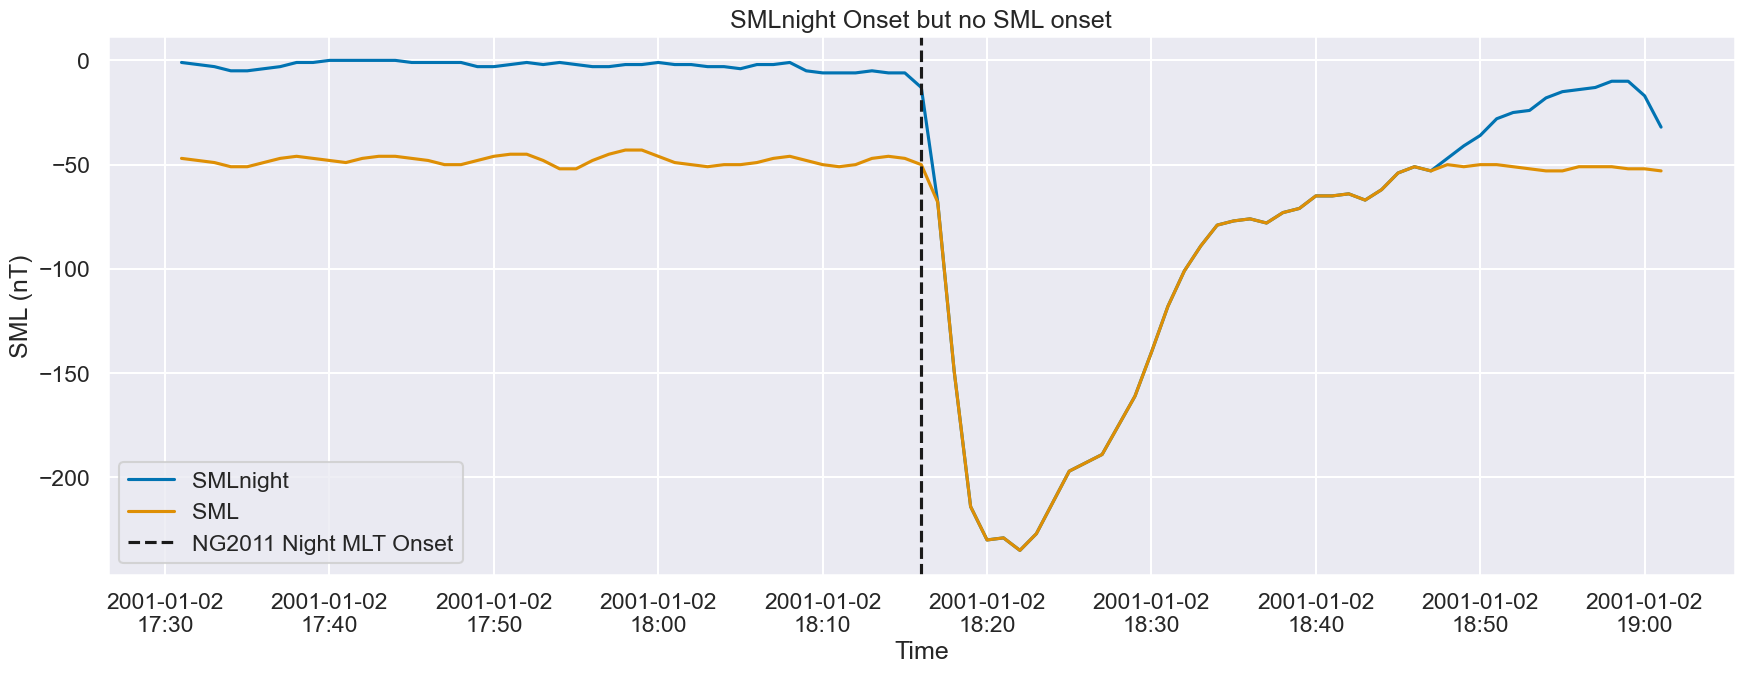

In [10]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_night['Date_UTC'], ng2011_2001['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLnightdf['Date_UTC'][SMLnightdf['Date_UTC'].between(tstart,tend)]
y = SMLnightdf['SMLnight'][SMLnightdf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLnight')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k',ls='--',label='NG2011 Night MLT Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('SMLnight Onset but no SML onset')
ax.xaxis.set_major_formatter(date_form)

In [11]:
ng2011_night[ng2011_night['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT_onset,SML_Minima,Date_UTC_minima
1,2001-01-02 18:16:00,"22, 23, 0",-235,2001-01-02 18:22:00


In [12]:
ng2011_2001[ng2011_2001['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT,MLAT,GLON,GLAT


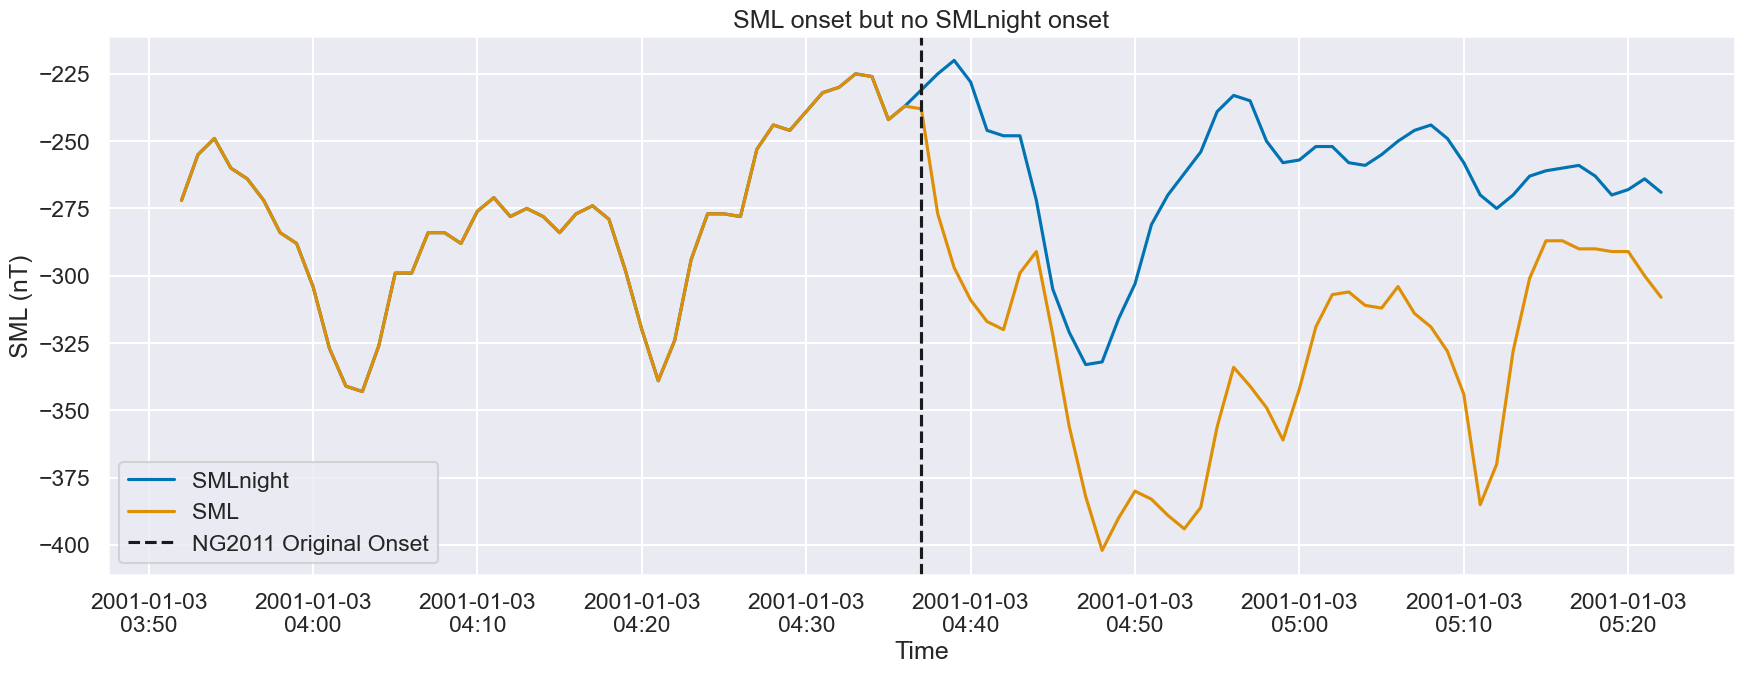

In [13]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_2001['Date_UTC'], ng2011_night['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLnightdf['Date_UTC'][SMLnightdf['Date_UTC'].between(tstart,tend)]
y = SMLnightdf['SMLnight'][SMLnightdf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLnight')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k', ls='--', label='NG2011 Original Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('SML onset but no SMLnight onset')
ax.xaxis.set_major_formatter(date_form)

In [14]:
ng2011_night[ng2011_night['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT_onset,SML_Minima,Date_UTC_minima


In [15]:
ng2011_2001[ng2011_2001['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT,MLAT,GLON,GLAT
3,2001-01-03 04:37:00,5.37,70.23,351.3,70.9


## Recreating the NG2011 Substorm onset algorithm

In [16]:
onsettimes = []
onsetsectors = []
sml_array = sml_lt_df[allsec_names].values

untilnext = 0
for index, __ in SMLalldf[:-30].iterrows():
    onsettime = SMLalldf['Date_UTC'][index]
    onsetsml = SMLalldf['SMLall'][index]
    onsetsector = np.where(sml_array[index]==onsetsml)[0]
    if untilnext > 1:
        untilnext -= 1
        continue
    if SMLalldf['SMLall'][index + 1] - onsetsml < -15:
        if SMLalldf['SMLall'][index + 2] - onsetsml < -30:
            if SMLalldf['SMLall'][index + 3] - onsetsml <= -45:
                if np.sum(SMLalldf['SMLall'][index + 4:index + 30])/26 - onsetsml < -100:
                    onsettimes.append(onsettime)
                    onsetsectors.append(', '.join([str(element) for element in onsetsector]))
                    untilnext = 20
    else:
        untilnext -= 1
        
ng2011_all = pd.DataFrame({'Date_UTC':onsettimes, 'MLT at onset':onsetsectors})

In [17]:
ng2011_all

,Date_UTC,MLT at onset
0,2001-01-01 06:23:00,"18, 19, 20"
1,2001-01-02 22:24:00,"0, 22, 23"
2,2001-01-03 02:56:00,"1, 2, 3"
3,2001-01-03 04:37:00,"4, 5, 6"
4,2001-01-03 11:03:00,"0, 1, 23"
...,...,...
1564,2001-12-31 16:23:00,"3, 4, 5"
1565,2001-12-31 18:14:00,"19, 20, 21"
1566,2001-12-31 18:53:00,"6, 7, 8"
1567,2001-12-31 20:39:00,"4, 5, 6"


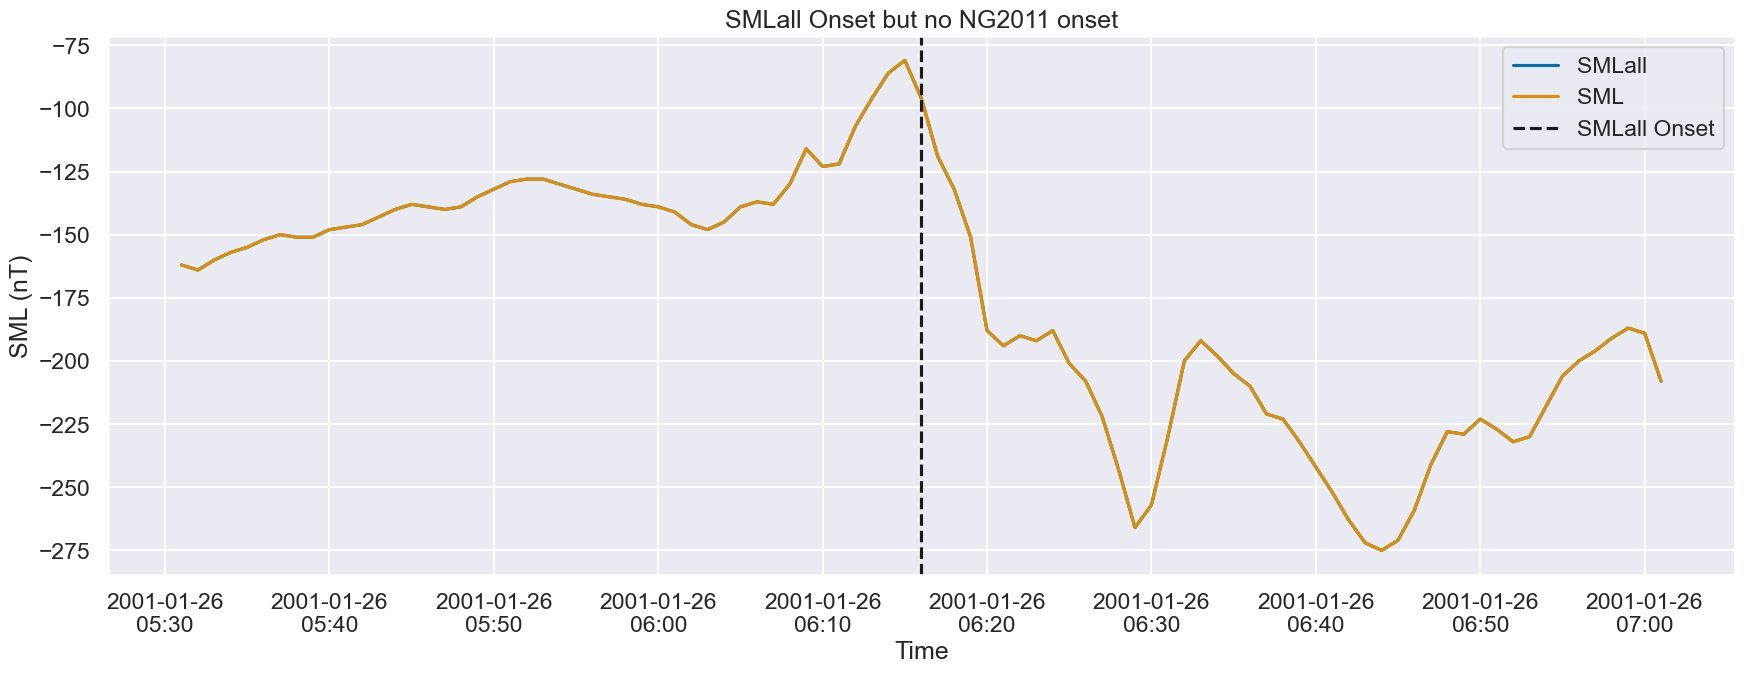

In [18]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_all['Date_UTC'], ng2011_2001['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLalldf['Date_UTC'][SMLalldf['Date_UTC'].between(tstart,tend)]
y = SMLalldf['SMLall'][SMLalldf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLall')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k',ls='--',label='SMLall Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('SMLall Onset but no NG2011 onset')
ax.xaxis.set_major_formatter(date_form)

In [19]:
ng2011_all[ng2011_all['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT at onset
87,2001-01-26 06:16:00,"3, 4, 5"


In [20]:
ng2011_2001[ng2011_2001['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT,MLAT,GLON,GLAT
87,2001-01-26 06:15:00,4.31,66.04,314.56,61.16


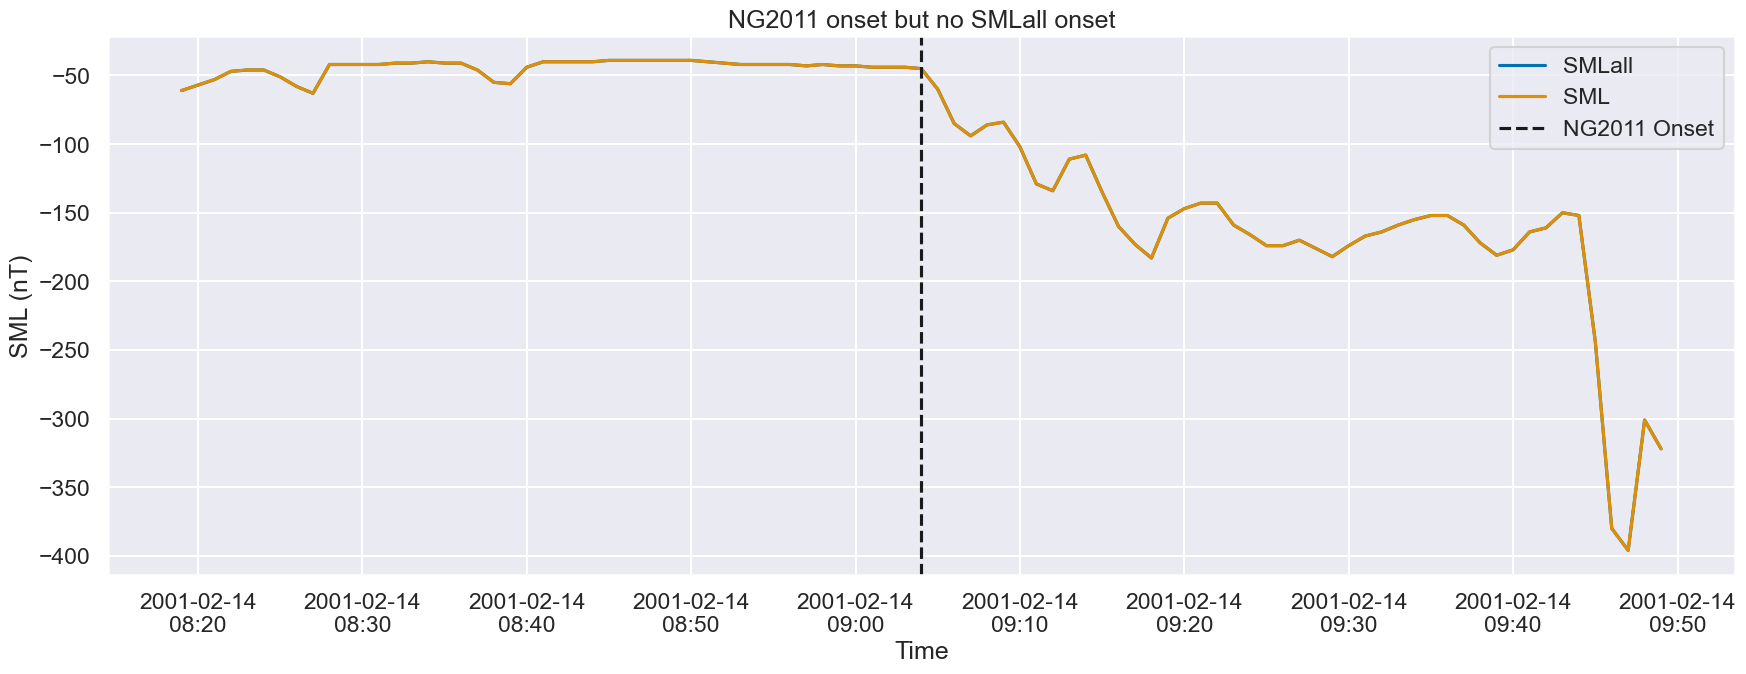

In [21]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_2001['Date_UTC'], ng2011_all['Date_UTC'])[1]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLalldf['Date_UTC'][SMLalldf['Date_UTC'].between(tstart,tend)]
y = SMLalldf['SMLall'][SMLalldf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLall')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k', ls='--', label='NG2011 Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('NG2011 onset but no SMLall onset')
ax.xaxis.set_major_formatter(date_form)

In [22]:
ng2011_all[ng2011_all['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT at onset
153,2001-02-14 09:44:00,"1, 2, 3"


In [23]:
ng2011_2001[ng2011_2001['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT,MLAT,GLON,GLAT
153,2001-02-14 09:04:00,6.89,72.99,309.28,67.02
154,2001-02-14 09:44:00,22.95,66.10,220.89,64.05


Realisation: Newell onset list taking onset location station as not the contributing station to SML at time of onset. Is SOPHIE the same as this.